# ARMマイコンでつくるダイレクト・サンプリングSDRを試す
トラ技2021/01から2021/05で連載されていた「ARMマイコンでつくるダイレクト・サンプリングSDR」(以下ARM-SDRと略す)を実際につくって試しみます。

記事を参考に作ったARM-SDRです。

<img src="images/J3/ARM-SDR.png" width="400" />

## トラ技2021/01のおさらい

ブレッドボードの配線をトラ技2021/01の図３から引用します。

<img src="images/J3/Fig-3.png" width="400" />

### NUCLIEO-F446REのアプリ
NUCLIEO-F446REのアプリは、mbedのサイトで公開されています。「SDR」で検索すると「SDR_AM_Rx_CIC_FIR」のプロジェクトが見つかりました。

富山の放送局に合わせてmain.cppのF_C_配列を以下のように修正しました。
```C++
// 各放送局の搬送波の周波数，単位： Hz
const float F_C_[] = {  648.0e3f,   // NHK 第１
                        738.0e3f,   // 北日本放送
                        954.0e3f,   // TBS ラジオ
                       1035.0e3f,   // NHK 第２                        
                       1134.0e3f,   // 文化放送
                       1242.0e3f,   // ニッポン放送
                       1422.0e3f};  // ラジオ日本
```

### ARMでダイレクト・サンプリングができた理由
コラム１にも書いてありますが、NUCLIEO-F446REに搭載されているSTM32F446REは、フラッシュ・メモリのプログラムをノーウェイトでアクセスできることが大きいです。他のCPUで試す場合には、CPUクロックの他にフラッシュ・メモリのアクセス時間にも注意必要です。


## RFフロントエンドについて
ここでの目的は、コラム２にあるAM受信機用アンプとバンドパスフィルタの総合周波数特性を求めることです。

RFフロントエンドの回路をトラ技2021/01の図２から引用します(ハイパス・フィルター、バンドパス・フィルターの値は筆者が付記))。

<img src="images/J3/Fig-2.png" width="500" />

コラム２では、周波数特性を以下のように求めたそうです。
- OPアンプの周波数1MHzのオープン・ループ・ゲインが30dB, ゲインの減衰率が20dB/dec
- バンドパスフィルタの周波数特性は、４端子回路のF行列の縦続接続の関係を使用



OPアンプの増幅は、R1=1kΩ、R3=4.7kΩの非反転増幅とすると、
$$
G = \frac{V_{out}}{V_{in}} = \frac{R_1 + R_3}{R_1} = 5.7倍 \simeq 15dB
$$

NJU77701のデータシートの利得/位相 対 周波数 特性例を引用します。
この図から20dB/decの減衰率が求まります。

<img src="images/J3/NJU77701_Gain.png" width="400" />

### ４端子行列（F行列）
できるだけ覚えることを少なくして、特性を求めることを考えてみましょう。

抵抗R、コンデンサーC、コイルLのインピーダンスは、$ Z_R = R, Z_C = \frac{1}{sC}, Z_L = sL $となります。

以下のような$ Z_1, Z_2 $の直列と並列のインピーダンスの回路について考えます(トラ技2013/8月号付録p26から引用)。

<img src="images/J3/F-Matrix.png" width="300" />

この場合のF行列は、直列、並列のインピーダンスを表す２つのマトリックスの積で表すことができます。

$$
\begin{bmatrix}
    V_1 \\
    i_1
\end{bmatrix} = 
\underbrace{
    \begin{bmatrix}
        1 & Z_i \\
        0 & 1
    \end{bmatrix}
}_{直列インピーダンス}
\underbrace{
    \begin{bmatrix}
        1 & 0 \\
        1/Z_2 & 1
    \end{bmatrix}
}_{並列インピーダンス}
\begin{bmatrix}
    V_2 \\
    i_2
\end{bmatrix}
$$

出力端子を開放したとき、＄i_2 = 0 $なので、これからゲインGは、以下のようになります。

$$
\begin{bmatrix}
    V_1 \\
    i_1
\end{bmatrix} = 
\begin{bmatrix}
    1 + Z_1/Z_2 & Z_1 \\
    1/Z_2 & 1
\end{bmatrix}
\begin{bmatrix}
    V_2 \\
    0
\end{bmatrix}
$$

$$
    G = \frac{V_2}{V_1} = \frac{Z_2}{Z_1 + Z_2}
$$

### ４端子の特性
MATLAB互換のライブラリPython-Controlを使って４端子の伝達関数を求め、特性曲線を出力してみましょう。

最初にPython-Controlをインストールします。


In [1]:
!pip -q install control

次に、$ Z_1, Z_2 $にバンドパス・フィルターの左のローパス・フィルター（LPF）の特性を計算します。

$$
Z_1 = R + sL
$$
$$
Z_2 = \frac{1}{sC}
$$
から$ G_L $は、次のようになります。
$$
G_L = \frac{1}{LC s^2 + RC s + 1}
$$

In [2]:
from control import matlab

R = 270.0
L = 22.0e-6
C = 330.0e-12
# tfの引数のnumrator, denominatorは、sの次元の高い順に指定係数を配列で指定する
GL = matlab.tf([1], [L*C, R*C, 1])
print(GL)


              1
-----------------------------
7.26e-15 s^2 + 8.91e-08 s + 1



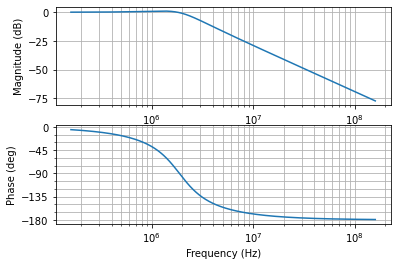

In [3]:
from matplotlib import pyplot as plt

matlab.bode(GL, Hz=True)
plt.show()

同様にハイパス・フィルター（HPF）の特性を計算します。

$$
Z_1 = \frac{1}{sC} + R 
$$
$$
Z_2 = sL
$$
から$ G_L $は、次のようになります。
$$
G_L = \frac{LC s^2}{LC s^2 + RC s + 1}
$$

In [4]:
R = 1000.0
L = 470.0e-6
C = 330.0e-12
# tfの引数のnumrator, denominatorは、sの次元の高い順に指定係数を配列で指定する
GH = matlab.tf([L*C, 0, 0], [L*C, R*C, 1])
print(GH)


        1.551e-13 s^2
-----------------------------
1.551e-13 s^2 + 3.3e-07 s + 1



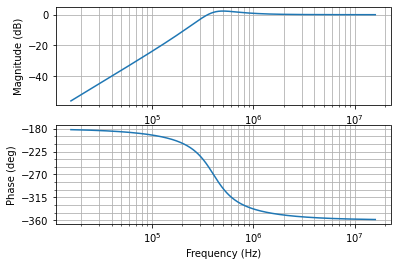

In [5]:
matlab.bode(GH, Hz=True)
plt.show()


                         1.551e-13 s^2
---------------------------------------------------------------
1.126e-27 s^4 + 1.622e-20 s^3 + 1.918e-13 s^2 + 4.191e-07 s + 1



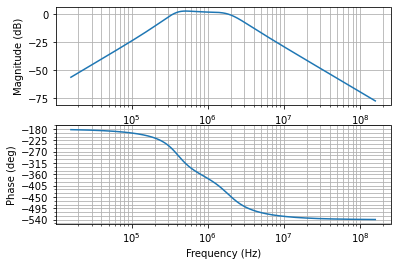

In [6]:
G = GH*GL
print(G)
matlab.bode(G, Hz=True)
plt.show()

## ネットワーク図
AnalogDiscoveryを使って、ネットワーク解析をしました。

<img src="images/J3/AnalogDiscovery.png" width="400" />

AnalogDiscoveryとの接続との接続は以下の通りです。

| AnalogDiscovery | RFフロントエンド |
| :-- | :-- |
| Scope Channel 1 Posigive(Orange) | Antena |
| Scope Channel 1 Negative(Orange/White) | GND |
| Waveform Generator 1(Yellow) | Antena |
| Ground(Black) | GND |

ネットワーク解析の結果は、以下の通りです。周波数は100kHzから5MHzまでとしました。

<img src="images/J3/Network.png" width="600" />

トラ技コラム２図AからAM受信機用アンプとバンドパスフィルタの総合周波数特性を引用します。

トラ技のコラム２の値より3〜5dBほど低い値ですが、形状はよく捉えていると思います。

<img src="images/J3/Fig-A.png" width="500" />

